In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import collections

In [2]:
h2_df = pd.read_csv('data/H2.csv')

In [3]:
h2_df.shape

(79330, 31)

In [4]:
h2_df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [5]:
time_series_h2 = h2_df.groupby(['ArrivalDateYear', 'ArrivalDateWeekNumber']).agg(
    count_total=('IsCanceled', 'count'),
    count_canceled=('IsCanceled', 'sum'),
    percent_canceled=('IsCanceled', 'mean')).reset_index()

In [6]:
time_series_h2.head()

,ArrivalDateYear,ArrivalDateWeekNumber,count_total,count_canceled,percent_canceled
0,2015,27,182,97,0.532967
1,2015,28,214,153,0.714953
2,2015,29,352,228,0.647727
3,2015,30,453,321,0.708609
4,2015,31,232,159,0.685345


In [7]:
time_series_h2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ArrivalDateYear        115 non-null    int64  
 1   ArrivalDateWeekNumber  115 non-null    int64  
 2   count_total            115 non-null    int64  
 3   count_canceled         115 non-null    int64  
 4   percent_canceled       115 non-null    float64
dtypes: float64(1), int64(4)
memory usage: 4.6 KB


In [8]:
time_series_h2['ArrivalDate'] = time_series_h2.apply(lambda x: datetime.strptime('%dW%d Mon' % (x.ArrivalDateYear, x.ArrivalDateWeekNumber),
                                                                                 '%YW%U %a'), axis=1)

In [9]:
time_series_h2.head()

,ArrivalDateYear,ArrivalDateWeekNumber,count_total,count_canceled,percent_canceled,ArrivalDate
0,2015,27,182,97,0.532967,2015-07-06
1,2015,28,214,153,0.714953,2015-07-13
2,2015,29,352,228,0.647727,2015-07-20
3,2015,30,453,321,0.708609,2015-07-27
4,2015,31,232,159,0.685345,2015-08-03


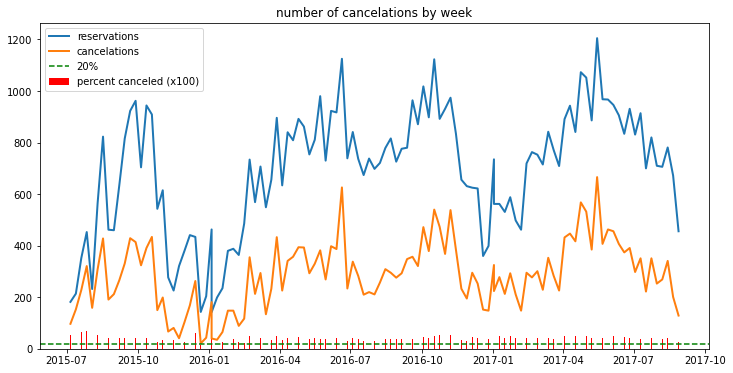

In [10]:
# plt.plot()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(time_series_h2['ArrivalDate'], time_series_h2['count_total'], lw=2, label="reservations")
ax.plot(time_series_h2['ArrivalDate'], time_series_h2['count_canceled'], lw=2, label="cancelations")
ax.bar(time_series_h2['ArrivalDate'], time_series_h2['percent_canceled'] * 100, lw=2, color='r', label="percent canceled (x100)")
ax.axhline(20, color='g', linestyle="--", label='20%')
year_loc = mdates.MonthLocator(interval=3)
year_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(year_loc)
ax.xaxis.set_major_formatter(year_fmt)
plt.legend()
plt.title('number of cancelations by week');

In [11]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

In [12]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=53, observed_time_series=observed_time_series)
  model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  return model

In [14]:
time_series_h2['count_canceled'] = time_series_h2['count_canceled'].astype(np.float32)

In [15]:
cancellation_model = build_model(time_series_h2['count_canceled']) # co2_by_month_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=cancellation_model)

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


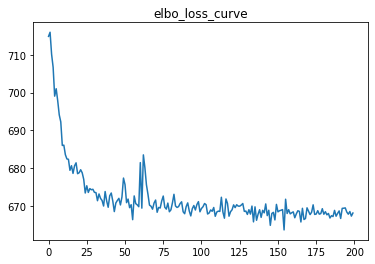

In [17]:
#@title Minimize the variational loss.

num_forecast_steps = 15 # Forecast the final weeks, given previous data
train_data = time_series_h2['count_canceled'][:-num_forecast_steps]

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=cancellation_model.joint_log_prob(
        observed_time_series=train_data),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.title('elbo_loss_curve')
plt.show();

In [18]:
# Draw samples from the variational posterior.
q_samples = variational_posteriors.sample(50)

print("Inferred parameters:")
for param in cancellation_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples[param.name], axis=0),
                              np.std(q_samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 9.245840072631836 +- 12.121460914611816
LocalLinearTrend/_level_scale: 24.80010986328125 +- 11.14705753326416
LocalLinearTrend/_slope_scale: 0.7724502682685852 +- 1.2476582527160645
Seasonal/_drift_scale: 113.96710205078125 +- 18.224069595336914


In [19]:
forecast_dist = tfp.sts.forecast(
    cancellation_model,
    observed_time_series=train_data,
    parameter_samples=q_samples,
    num_steps_forecast=num_forecast_steps)

In [20]:
num_samples=10

forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean().numpy()[..., 0],
    forecast_dist.stddev().numpy()[..., 0],
    forecast_dist.sample(num_samples).numpy()[..., 0])

In [21]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]

  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast * timedelta(days=7), timedelta(days=7),
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

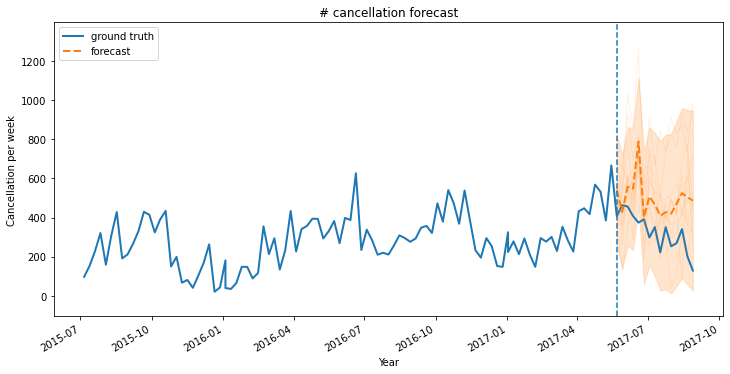

In [23]:
the_dates = time_series_h2['ArrivalDate']

fig, ax = plot_forecast(
    the_dates, time_series_h2['count_canceled'],
    forecast_mean, forecast_scale, forecast_samples,
    x_locator=year_loc,
    x_formatter=year_fmt,
    title="# cancellation forecast")
ax.axvline(the_dates.iloc[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Cancellation per week")
ax.set_xlabel("Year")
fig.autofmt_xdate()

In [24]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(
    cancellation_model,
    observed_time_series= time_series_h2['count_canceled'],
    parameter_samples=q_samples)

In [25]:
component_means_, component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

In [26]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

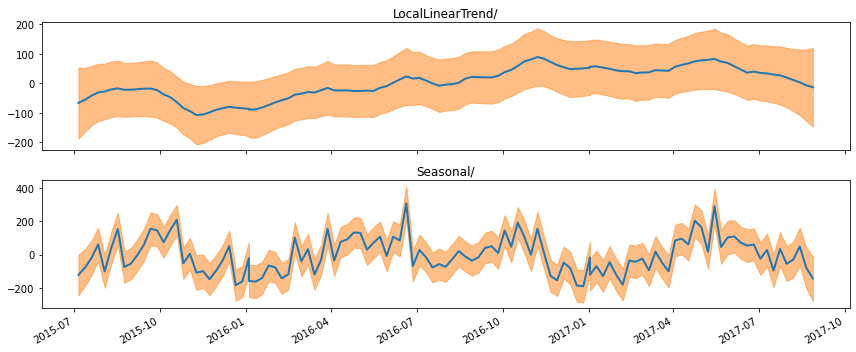

In [27]:
plot_components( time_series_h2['ArrivalDate'], component_means_, component_stddevs_,
                    x_locator=year_loc, x_formatter=year_fmt);

In [28]:
one_step_dist = sts.one_step_predictive(
    cancellation_model,
    observed_time_series=time_series_h2['count_canceled'],
    parameter_samples=q_samples)

one_step_mean, one_step_scale = (
    one_step_dist.mean().numpy(), one_step_dist.stddev().numpy())

In [29]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

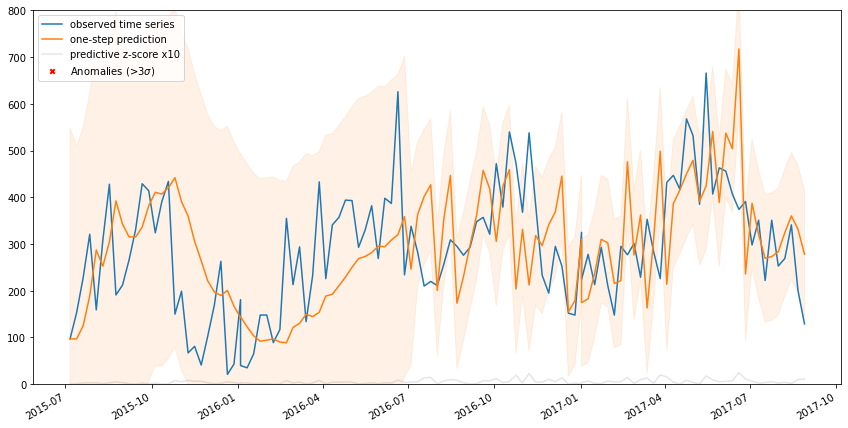

In [35]:
fig, ax = plot_one_step_predictive(
    time_series_h2['ArrivalDate'], time_series_h2['count_canceled'],
    one_step_mean, one_step_scale,
    x_locator=year_loc, x_formatter=year_fmt)
ax.set_ylim(0, 800)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((time_series_h2['count_canceled'] - one_step_mean) /
                 one_step_scale)
anomalies = zscores > 3.0
ax.scatter(time_series_h2['ArrivalDate'][anomalies],
           time_series_h2['count_canceled'][anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(time_series_h2['ArrivalDate'], zscores * 10, color="black", alpha=0.1, label='predictive z-score x10')
ax.legend()
plt.show()

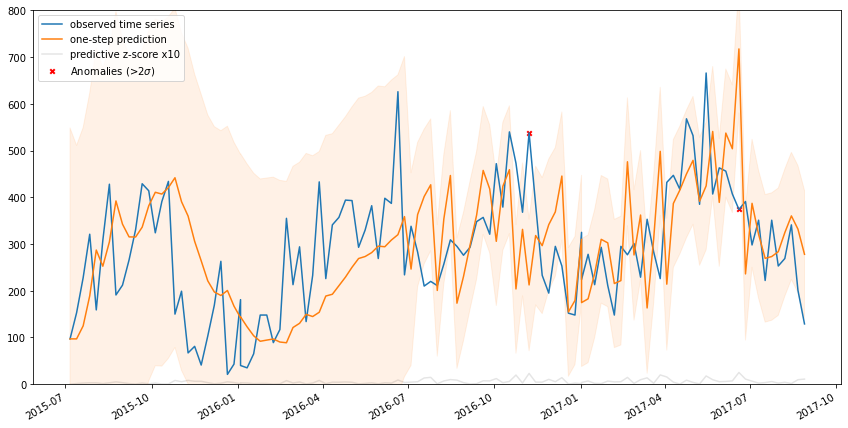

In [38]:
fig, ax = plot_one_step_predictive(
    time_series_h2['ArrivalDate'], time_series_h2['count_canceled'],
    one_step_mean, one_step_scale,
    x_locator=year_loc, x_formatter=year_fmt)
ax.set_ylim(0, 800)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((time_series_h2['count_canceled'] - one_step_mean) /
                 one_step_scale)
anomalies = zscores > 2.0
ax.scatter(time_series_h2['ArrivalDate'][anomalies],
           time_series_h2['count_canceled'][anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>2$\sigma$)")
ax.plot(time_series_h2['ArrivalDate'], zscores * 10, color="black", alpha=0.1, label='predictive z-score x10')
ax.legend()
plt.show()